# Descriptive Statistics
* Test for stationarity: Augmented Dickey-Fuller Test (unit test)
    * if p value is <0.05, reject the null hypothesis and assume the dataset is stationary
    * if p value is >0.05, fail to rekect the null hypothesis
* Granger Causalisty Tests - Hypothesis testto determine if one time series is useful in foreasting another - otherwise known as causality
    * tests if when one time series changes, if it causes another time series to change as well in the future - one time series causes changes in another time series
* Evaluating forecasting
    * MAE
    * MSE
    * RMSE
    * AIC - Akaile Information Criterion
        * Estimates the quality of each model relative to the others
        * Penalties are provided for the number of parameters used in an effort to thwart overfitting (takes into consideration the complexity of the model that only provides a minor improvement in performance)
    * BIC - Bayesian Information Criterion - similar to AIC but takes a Bayesian approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load seasonal dataset
df1 = pd.read_csv('/Users/tanojudawattage/1_tanoj/0.00_Cloud_Computing_and_Streaming_Tech/Python_for_Time_Series_Files_JosePortilla/Data/airline_passengers.csv', parse_dates=True, index_col='Month')
df1.index.freq = 'MS'

# Load a nonseasonal dataset
df2 = pd.read_csv('/Users/tanojudawattage/1_tanoj/0.00_Cloud_Computing_and_Streaming_Tech/Python_for_Time_Series_Files_JosePortilla/Data/DailyTotalFemaleBirths.csv', parse_dates=True, index_col='Date')
df2.index.freq = 'D'

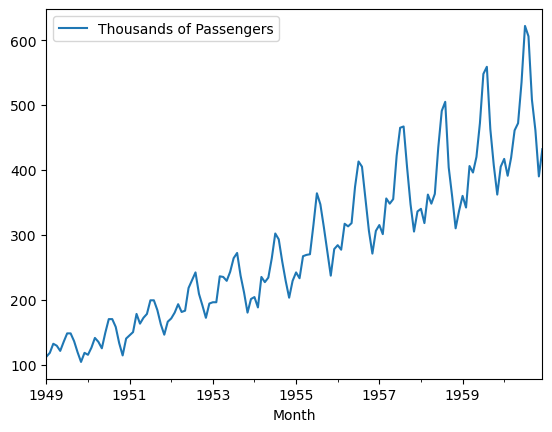

In [3]:
df1.plot()
plt.show()

# Augmented Dickey-Fuller Test

In [4]:
from statsmodels.tsa.stattools import adfuller

In [10]:
help(adfuller)

Help on function adfuller in module statsmodels.tsa.stattools:

adfuller(
    x,
    maxlag: 'int | None' = None,
    regression='c',
    autolag='AIC',
    store=False,
    regresults=False
)
    Augmented Dickey-Fuller unit root test.

    The Augmented Dickey-Fuller test can be used to test for a unit root in a
    univariate process in the presence of serial correlation.

    Parameters
    ----------
    x : array_like, 1d
        The data series to test.
    maxlag : {None, int}
        Maximum lag which is included in test, default value of
        12*(nobs/100)^{1/4} is used when ``None``.
    regression : {"c","ct","ctt","n"}
        Constant and trend order to include in regression.

        * "c" : constant only (default).
        * "ct" : constant and trend.
        * "ctt" : constant, and linear and quadratic trend.
        * "n" : no constant, no trend.

    autolag : {"AIC", "BIC", "t-stat", None}
        Method to use when automatically determining the lag length among 

In [5]:
adfuller(df1['Thousands of Passengers'])

(np.float64(0.8153688792060549),
 np.float64(0.9918802434376411),
 13,
 130,
 {'1%': np.float64(-3.4816817173418295),
  '5%': np.float64(-2.8840418343195267),
  '10%': np.float64(-2.578770059171598)},
 np.float64(996.692930839019))

## Clean up the output

In [6]:
# dataframe to hold values
dftest = adfuller(df1['Thousands of Passengers'])
dfout = pd.Series(dftest[0:4], index=['ADF Test Statistic', 'p-value', '#Lags Used', 'Observations'])

In [7]:
dfout

ADF Test Statistic      0.815369
p-value                 0.991880
#Lags Used             13.000000
Observations          130.000000
dtype: float64

In [8]:
for key, value in dftest[4].items():
    dfout[f'critical value ({key})'] = value

In [9]:
dfout

ADF Test Statistic        0.815369
p-value                   0.991880
#Lags Used               13.000000
Observations            130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
dtype: float64

## Function for running the Augmented Dickey-Fuller test

In [11]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [12]:
adf_test(df1['Thousands of Passengers'], title='Thousands of Passengers')

Augmented Dickey-Fuller Test: Thousands of Passengers
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


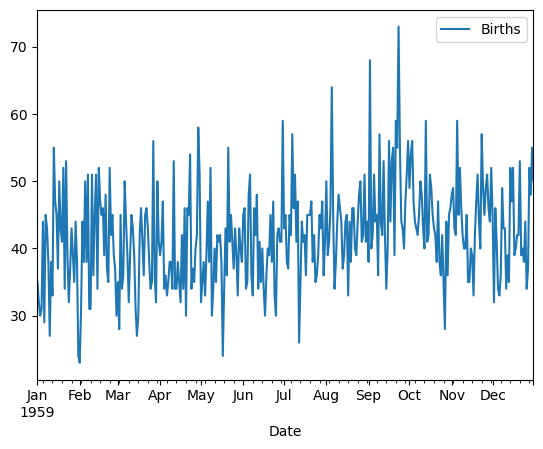

In [13]:
df2.plot()
plt.show()

In [14]:
adf_test(df2['Births'], title='Births')

Augmented Dickey-Fuller Test: Births
ADF test statistic       -4.808291
p-value                   0.000052
# lags used               6.000000
# observations          358.000000
critical value (1%)      -3.448749
critical value (5%)      -2.869647
critical value (10%)     -2.571089
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


# The Granger Causality Test

The Granger causality test is a statistical hypothesis test that determines if one time series can be used to forecast another. It's not a true measure of causation but rather assesses if past values of a "cause" variable improve the prediction of a "effect" variable, beyond what can be predicted by the "effect" variable's own past values. For example, it can be used to see if a rich city's past exports can predict a poor city's current exports.

In [15]:
# Load a seasonal dataset with multiple seasonality
df3 = pd.read_csv('/Users/tanojudawattage/1_tanoj/0.00_Cloud_Computing_and_Streaming_Tech/Python_for_Time_Series_Files_JosePortilla/Data/samples.csv', parse_dates=True, index_col=0)
# Set the index frequency to monthly start
df3.index.freq = 'MS'

In [16]:
df3.head()

,a,b,c,d
1950-01-01,36,27,0,67
1950-02-01,58,22,3,31
1950-03-01,61,17,5,67
1950-04-01,37,15,8,47
1950-05-01,66,13,8,62


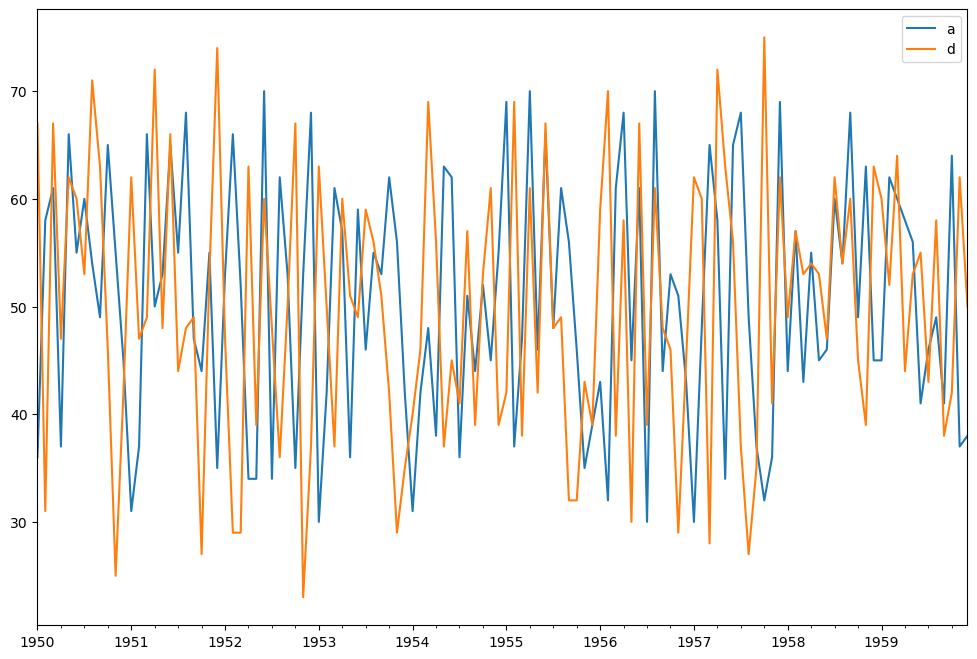

In [18]:
df3[['a', 'd']].plot(figsize=(12,8))
plt.show()

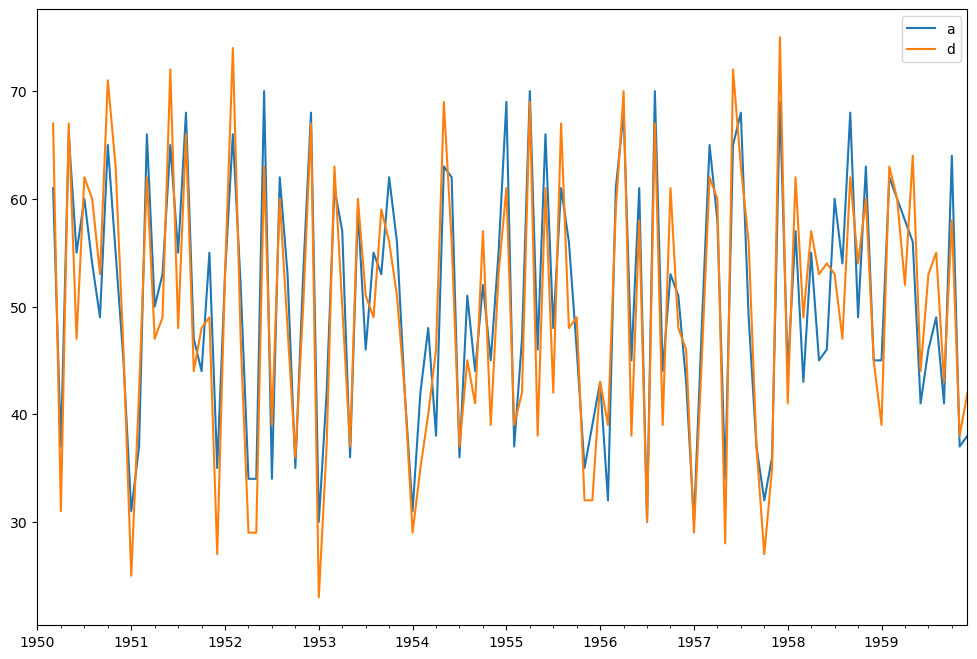

In [21]:
# plot out 'a' column at index 2 and all the way to the end
df3['a'].iloc[2:].plot(figsize=(12,8), legend=True)
# plot out 'd' column shifted by 2
df3['d'].shift(2).plot(legend=True)
plt.show()

In [22]:
# import grangercausalitytests
from statsmodels.tsa.stattools import grangercausalitytests

In [23]:
grangercausalitytests(df3[['a', 'd']], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=136.1258, p=0.0000  

{np.int64(1): ({'ssr_ftest': (np.float64(1.7051251051681242),
    np.float64(0.1942027811635669),
    np.float64(116.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(1.749223168232817),
    np.float64(0.18597442074424078),
    np.int64(1)),
   'lrtest': (np.float64(1.7364915553187075),
    np.float64(0.18758398456227507),
    np.int64(1)),
   'params_ftest': (np.float64(1.705125105168112),
    np.float64(0.1942027811635688),
    np.float64(116.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(286.0339426255611),
    np.float64(6.025362015680703e-45),
    np.float64(113.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(597.38062353657),
    np.float64(1.9074176679050054e-130),
    np.int64(2)),
   'lrtest': (np.float64(212.65135382912013),
    np.float64(6.658022084670888e-47),
    np.int64(2)),
   'params_ftest': (np.float64(286.03394262555423),
    np.float64(6.02536201568752e-45),
    np.float64(113.0),
    2.0)},
   array([[0., 0., 1., 0., 0.

In [24]:
# compare 'b' and 'd' for granger causality
grangercausalitytests(df3[['b', 'd']], maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.5619  , p=0.2114  , df=1
likelihood ratio test: chi2=1.5517  , p=0.2129  , df=1
parameter F test:         F=1.5225  , p=0.2197  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=0.9086  , p=0.6349  , df=2
likelihood ratio test: chi2=0.9051  , p=0.6360  , df=2
parameter F test:         F=0.4350  , p=0.6483  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=1.7018  , p=0.6365  , df=3
likelihood ratio test: chi2=1.6895  , p=0.6393  , df=3
parameter F test:         F=0.5333  , p=0.6604  , df_denom=110, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7084  , p=0.5879  

{np.int64(1): ({'ssr_ftest': (np.float64(1.5225271098609765),
    np.float64(0.2197316060388221),
    np.float64(116.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(1.5619028109780708),
    np.float64(0.21138682952677978),
    np.int64(1)),
   'lrtest': (np.float64(1.5517414581131561),
    np.float64(0.21287853854122682),
    np.int64(1)),
   'params_ftest': (np.float64(1.5225271098609747),
    np.float64(0.2197316060388221),
    np.float64(116.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(0.4350444134913967),
    np.float64(0.6483153418342347),
    np.float64(113.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(0.9085883326015011),
    np.float64(0.6348959407829895),
    np.int64(2)),
   'lrtest': (np.float64(0.905108165651427),
    np.float64(0.636001674473372),
    np.int64(2)),
   'params_ftest': (np.float64(0.4350444134913945),
    np.float64(0.6483153418342347),
    np.float64(113.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
      

# Evaluating Forecast Accuracy and Seasonality with Month and Quarter Plots

In [26]:
# create a datafream
np.random.seed(42)
df = pd.DataFrame(np.random.randint(20, 30, (50,2)), columns=['test', 'predictions'])


In [27]:
df.head()

,test,predictions
0,26,23
1,27,24
2,26,29
3,22,26
4,27,24


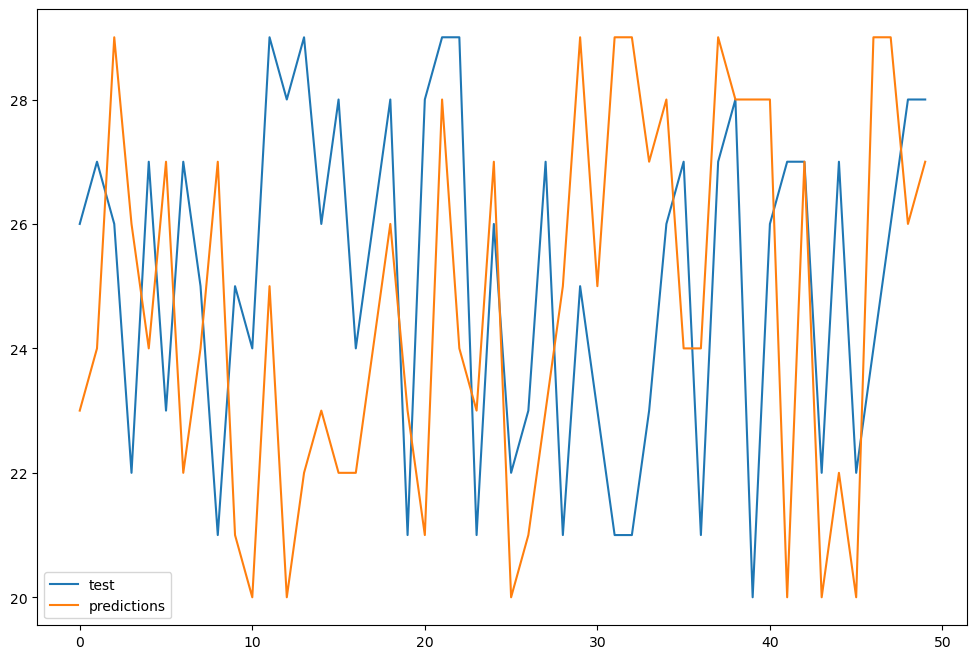

In [28]:
df.plot(figsize=(12,8))
plt.show()

## Evaluating errors

In [30]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

In [31]:
mse(df['test'], df['predictions'])

np.float64(17.02)

In [32]:
rmse(df['test'], df['predictions'])

np.float64(4.125530268947253)

In [33]:
meanabs(df['test'], df['predictions'])

np.float64(3.54)

## Month and Quarter Plots

In [34]:
df = pd.read_csv('/Users/tanojudawattage/1_tanoj/0.00_Cloud_Computing_and_Streaming_Tech/Python_for_Time_Series_Files_JosePortilla/Data/airline_passengers.csv', parse_dates=True, index_col='Month')

In [35]:
df.index.freq = 'MS'

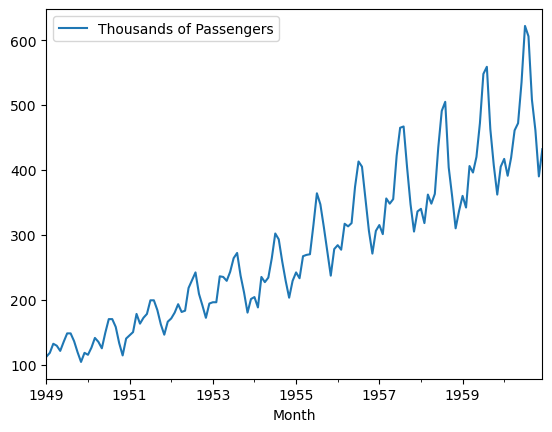

In [37]:
df.plot()
plt.show()

In [38]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

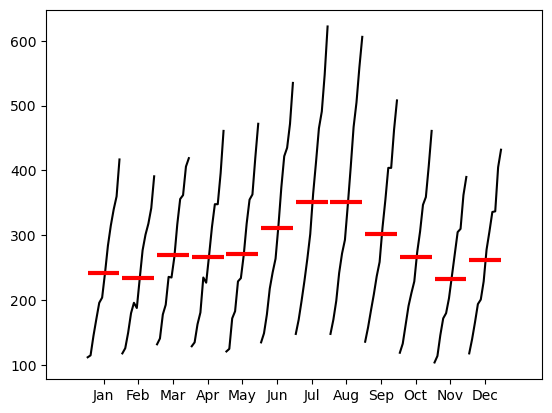

In [39]:
month_plot(df['Thousands of Passengers'])
plt.show()

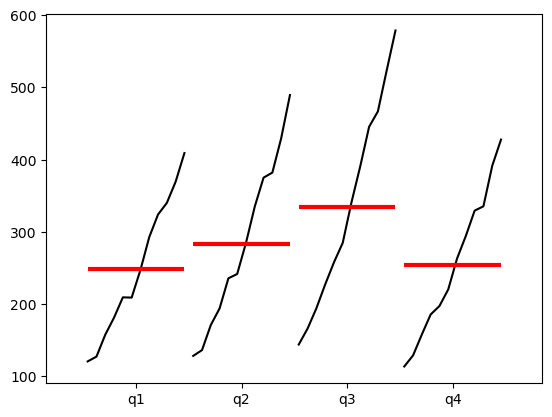

In [40]:
# resample to quarterly data and plot since dataframe is monthly
dfq = df['Thousands of Passengers'].resample(rule = 'Q').mean()
quarter_plot(dfq)
plt.show()